<h1 align="center">GPR Testing</h1>

## About GPR Algorithm

Think of GPR as a "smart" interpolation method that uses Bayesian probability.
 Instead of fitting a rigid function like a polynomial, you define a kernel, which acts as a prior describing the expected properties of the function (e.g., "I expect this curve to be very smooth").
  The GPR then calculates the most probable function (the "posterior") that fits your observed data points, given those properties. The key benefit is that it doesn't just return a single "best-fit" line;
   it returns a full probability distribution, giving you the mean prediction and a confidence interval (variance) for how certain it is.

## Content of Notebook:

1)Create a signal with background,spectral line at 1420MHz and noise.
2)Using the GPR Algorithm i will try to remove the background of the signal and keep the spectral line
3)I will experiment with the parameters of the algorithm and comment the results
4)I will try the algorithm in different signals
5)Compare the GPR with the ICA Algorithm

## Import Libraries

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Χρειαζόμαστε GPR και Kernels από το scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

## Implementation of the GPR Algorithm as a function 

## Create Signal in frequencies 1418-1422 with 1024 samples

Τα 'τυφλά' δεδομένα φορτώθηκαν επιτυχώς!
Διαστάσεις 'X' (Συχνότητες): (1024, 1)
Διαστάσεις 'y' (Σήμα): (1024,)


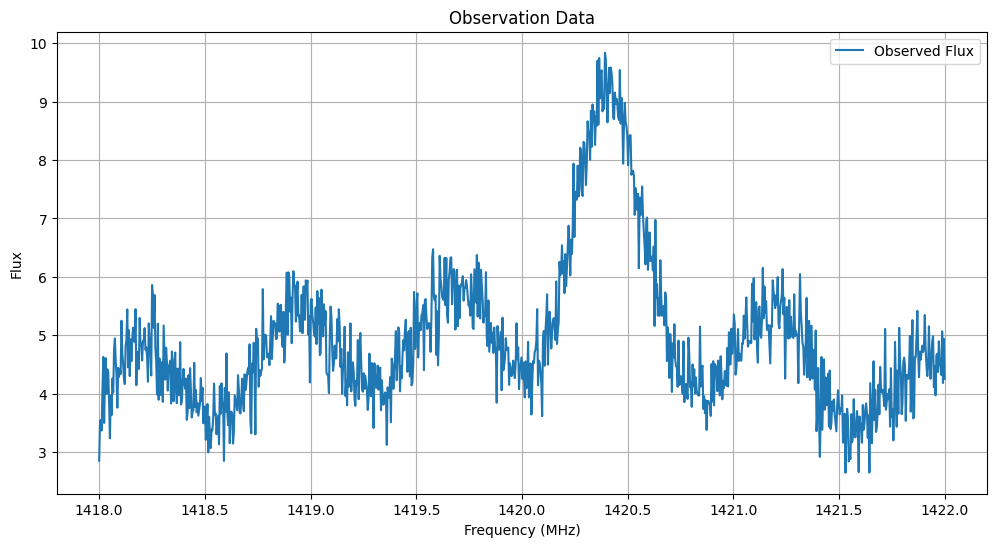

In [94]:
# 1. Άξονας Συχνοτήτων
frequencies = np.linspace(1418, 1422, 1024)

# 2. "Κρυφές" Συναρτήσεις
bg_poly = 5.0 - 0.3 * (frequencies - 1420)**2
bg_sine = 0.8 * np.sin(2 * np.pi * (frequencies - 1418) / 0.75)
line = 3.5 * np.exp(-((frequencies - 1420.4)**2) / (2 * 0.15**2))
noise = np.random.normal(0, 0.4, frequencies.shape)

# 3. Το Τελικό Σήμα Παρατήρησης
y_observed = bg_poly + bg_sine + line + noise


# 4. Μετατροπή για το scikit-learn
# Το GPR θέλει τον άξονα Χ (συχνότητες) σε μορφή 2D
X_observed = frequencies.reshape(-1, 1)

print("Τα 'τυφλά' δεδομένα φορτώθηκαν επιτυχώς!")
print(f"Διαστάσεις 'X' (Συχνότητες): {X_observed.shape}")
print(f"Διαστάσεις 'y' (Σήμα): {y_observed.shape}")

# --- Δοκιμαστικό Plot για τα δεδομένα ---
plt.figure(figsize=(12, 6))
plt.title("Observation Data")
plt.plot(frequencies, y_observed, label="Observed Flux")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True)
plt.show()

## Step 1 : Definition of Kernels

In [95]:
#Defintion of foreground_kernel 
kernel_foreground = 2*RBF(length_scale=0.25,length_scale_bounds=(0.1 , 0.5))
# 2 -> first estimation in the amplitude of the signal according to the plot
# length_scale = 0.25 -> every 0.5 MHz i cann see from the plot that the signal change monotony approximantly in the middle so i select 0.25
#length_scale_bounds = (0.1 , 0.5) -> i will let the optimizer try values but not bigger than 0.5 because the curves in every 0.5MHz will mix up the solution

#We will not define spectral line kernel because we can see the frequencies where the spectal line is and we will make a mask ay these freequencies

#Noise Kernel
noise_kernel = WhiteKernel(0.2 , noise_level_bounds=(1e-5,1.0))
# 0.2 -> random estimation but i select a small number because i can see that the signal is noisy 
# i set bounds enough for the optimizer to test 

#total kernel = foreground_kernel + noise_ kernel
total_kernel = kernel_foreground + noise_kernel

## Step 2:Definition of Mask

 In our GPR Algorithm we didnt use a spectral line kernel because our goal is to find the background and remove it from the inital observation.As a result we must hide the data of the spectral line from the algorithm because the GPR will try to model the whole signal.The method i will use is to use an algorithm to find the peak area and i will hide this area from the algorithm.I will use the Peak Prominence algorithm.

### Peak Prominence

Training GPR with 861 samples


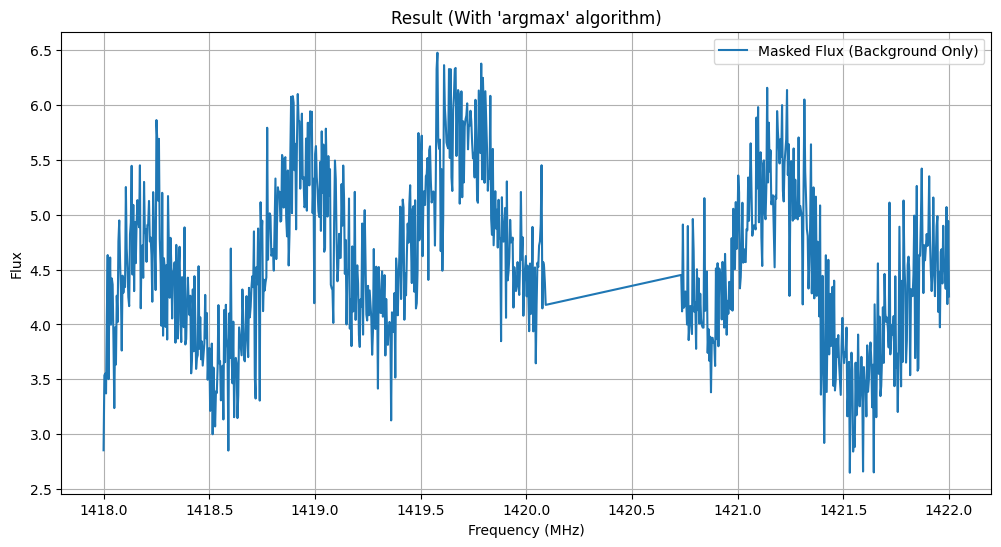

In [96]:

# --- Step 1: Smoothing (Cleans up the "jitter") ---
# Apply a Savitzky-Golay filter to smooth out high-frequency noise
y_smooth = savgol_filter(y_observed, window_length=11, polyorder=1)

noise_std = np.std(np.diff(y_smooth))
# --- Step 2: Find ALL "Real" Peaks ---
# We set a fixed threshold to catch all ripples AND the main line,
peaks, properties = find_peaks(
    y_smooth,
    prominence=5*noise_std,  # <-- FIXED, LOGICAL THRESHOLD
    width=10         # <-- Keep a minimum width
)

# --- Step 3: Select the "Main" Line (The `argmax` Logic) ---
if len(peaks) > 0:
    # Get the list of all found prominences
    all_prominences = properties['prominences']
    
    # Find the INDEX of the peak with the MAXIMUM prominence
    idx_of_main_line = np.argmax(all_prominences)

    # Get the boundaries ("shoulders") of ONLY this one peak
    # We use 'left_ips' and 'right_ips' (interpolated positions at half-prominence)
    main_line_left = properties['left_ips'][idx_of_main_line]
    main_line_right = properties['right_ips'][idx_of_main_line]

    # --- Add padding ---
    # Convert to integer and expand the region to ensure
    # the "feet" of the line are also masked.
    main_line_left = int(main_line_left) - 30
    main_line_right = int(main_line_right) + 30

    # --- Step 4: Create the Mask ---
    mask_background = np.ones_like(y_observed, dtype=bool) # True = Keep it (Background)
    mask_background[main_line_left : main_line_right + 1] = False # False = Discard it (Line)

    # --- Step 5: Apply the Mask ---
    x_mask = frequencies[mask_background].reshape(-1,1)
    y_mask = y_observed[mask_background] # Use the ORIGINAL (noisy) y_observed
    print(f"Training GPR with {len(y_mask)} samples")

    # --- Step 6: Check the Result ---
    plt.figure(figsize=(12, 6))
    plt.title("Result (With 'argmax' algorithm)")
    plt.plot(x_mask, y_mask,  markersize=2, label="Masked Flux (Background Only)")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Flux")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    # Fallback if no peaks are found with the current settings
    print("NO PEAKS FOUND. Try lowering 'prominence' to 0.1 or 0.05.")

## Step 3: Construction of Agent

In [97]:
#initialization of the gpr algorithm
gpr = GaussianProcessRegressor(kernel=total_kernel,alpha=0.0,optimizer="fmin_l_bfgs_b",n_restarts_optimizer=5)
#restart =5 -> for start i will give the optimizer 5 loops and every time we will add and see the results
#alpha = 0 -> we have defined noise kernel so we dont need to add alpha

## Step 4:Fitting 

In [98]:
gpr.fit(x_mask,y_mask)
baseline_gpr = gpr.predict(X_observed)
spectral_line = y_observed - baseline_gpr
print("Background Removed.")

Background Removed.


## Error Estimation

Summary of the Final Evaluation.

We will directly compare our "extracted line" (which we got from y_observed - gpr_baseline) against the "true line" (the ground truth). This allows us to precisely measure how successful our entire background removal process was.

Plots: We will visually check how well the two lines overlap and plot the "final error" (the difference between them).

Metrics (RMSE, $R^2$): We will calculate metrics to get a final score. The $R^2$ will tell us what percentage of the true line's shape we successfully recovered.

In [110]:
# --- STEP 1: Calculate the Final Metrics ---
spectral_line_smooth = savgol_filter(spectral_line,window_length=21,polyorder=1)
rmse_line = np.sqrt(mean_squared_error(line, spectral_line_smooth))
r2_line = r2_score(line, spectral_line_smooth)
mae_line = mean_absolute_error(line, spectral_line_smooth)

print("--- Spectral Line Extraction Evaluation ---")
print(f"Line RMSE: {rmse_line:.4f}")
print(f"Line R-squared (R²): {r2_line:.4f}")
print(f"Line MAE: {mae_line:.4f}")
print("-----------------------------------------")

--- Spectral Line Extraction Evaluation ---
Line RMSE: 0.2643
Line R-squared (R²): 0.9009
Line MAE: 0.1488
-----------------------------------------


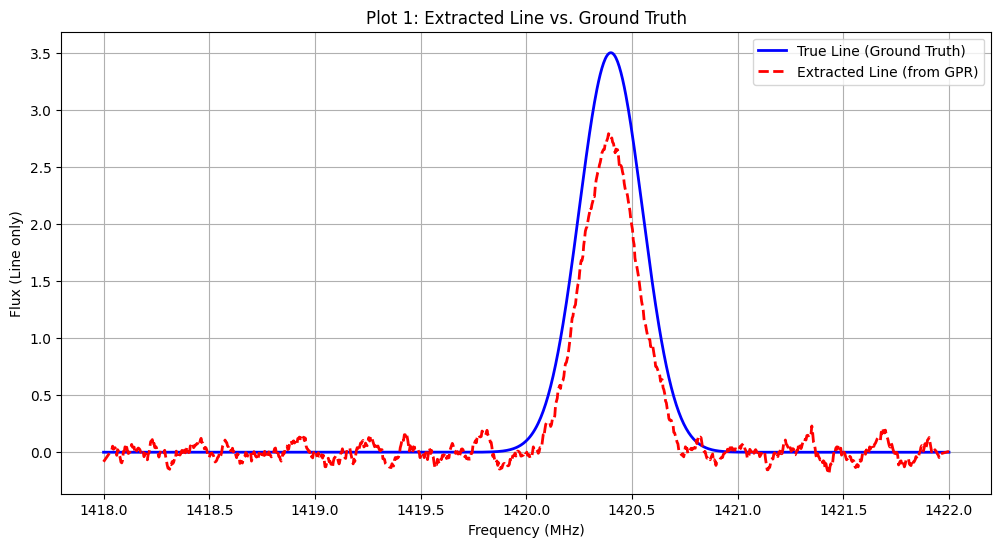

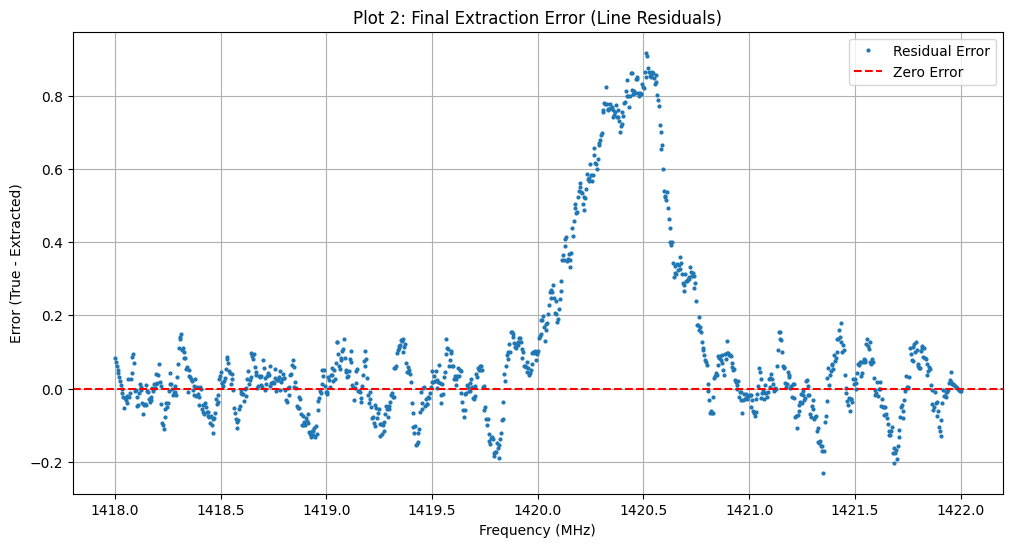

In [111]:
# --- STEP 4: Generate Plots ---
line_residuals = line - spectral_line_smooth
# --- Plot 1: Direct Overlap ---
plt.figure(figsize=(12, 6))
plt.title("Plot 1: Extracted Line vs. Ground Truth")
plt.plot(frequencies, line, 'b-', label="True Line (Ground Truth)", linewidth=2)
plt.plot(frequencies, spectral_line_smooth, 'r--', label="Extracted Line (from GPR)", linewidth=2)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux (Line only)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Line Residuals ---
plt.figure(figsize=(12, 6))
plt.title("Plot 2: Final Extraction Error (Line Residuals)")
plt.plot(frequencies, line_residuals, 'o', markersize=2, label="Residual Error")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Error (True - Extracted)")
plt.legend()
plt.grid(True)
plt.show()